<a href="https://colab.research.google.com/github/Crayfi/Datasets/blob/main/Trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div
    
def get_state(parameters, t, window_size = 20):
    outside = []
    d = t - window_size + 1
    for parameter in parameters:
        block = (
            parameter[d : t + 1]
            if d >= 0
            else -d * [parameter[0]] + parameter[0 : t + 1]
        )
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        for i in range(1, window_size, 1):
            res.append(block[i] - block[0])
        outside.append(res)
    return np.array(outside).reshape((1, -1))

In [ ]:
df = pd.read_csv('NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [ ]:
parameters = [df['Close'].tolist(), df['Total Trade Quantity'].tolist(), df['High'].tolist(), df['Low'].tolist(), df['Turnover (Lacs)'].tolist()]
skip = 1
layer_size = 750
output_size = 5
window_size = 20
##stocks = [i for i in os.listdir(os.getcwd()) if '.csv' in i and not 'TWTR' in i]
stocks= ['NSE-TATAGLOBAL.csv']

population_size = 15
sigma = 0.1
learning_rate = 0.03
max_buy = 7
max_sell = 14

In [ ]:
len_inventory = 1
len_shortinventory = 1
z_inventory = 1
z_shortinventory = 1
z_capital = 2
concat_parameters = np.concatenate([get_state(parameters, 20, window_size), [[len_inventory, z_inventory, len_shortinventory, z_shortinventory, z_capital]]], axis = 1)

In [ ]:
print(parameters[0])
print(concat_parameters)

[121.55, 120.9, 120.65, 117.6, 118.65, 118.25, 116.6, 116.05, 117.3, 118.3, 116.5, 114.05, 112.1, 112.85, 112.3, 113.9, 112.55, 114.15, 111.25, 110.1, 108.85, 113.05, 111.5, 116.7, 116.45, 117.0, 118.15, 117.75, 117.6, 120.5, 123.0, 122.4, 122.15, 123.15, 127.7, 127.25, 127.8, 125.95, 123.9, 123.25, 122.15, 122.65, 124.55, 122.5, 120.8, 123.55, 125.1, 123.6, 122.85, 121.5, 120.2, 123.5, 124.65, 127.0, 129.3, 133.4, 132.6, 134.25, 131.0, 133.75, 133.05, 129.85, 129.6, 129.75, 129.35, 130.4, 128.55, 128.45, 127.35, 127.25, 128.95, 124.65, 124.55, 125.15, 124.55, 124.3, 125.6, 125.15, 127.4, 131.9, 128.1, 124.85, 124.75, 121.2, 119.6, 120.1, 119.9, 117.2, 116.8, 109.95, 112.45, 112.95, 112.95, 114.75, 115.25, 114.1, 114.95, 115.25, 114.85, 111.5, 110.95, 112.8, 114.1, 114.8, 115.15, 115.45, 115.8, 113.6, 112.4, 112.5, 109.75, 109.55, 109.4, 107.25, 108.1, 111.5, 113.1, 112.3, 111.0, 108.3, 104.25, 101.9, 103.75, 103.25, 104.4, 104.9, 104.75, 104.95, 106.5, 105.65, 106.25, 106.2, 106.35, 9

In [ ]:
input_size = concat_parameters.shape[1] 
input_size

195

In [ ]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights
    
    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')
        
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.rand(input_size, layer_size)
            * np.sqrt(1 / (input_size + layer_size)),
            np.random.rand(layer_size, output_size)
            * np.sqrt(1 / (layer_size + output_size)),
            np.random.randn(layer_size, 1),
            np.random.randn(layer_size, 1),
            np.zeros((layer_size, 1)),
            np.zeros((layer_size, 1)),
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-2]
        decision = np.dot(feed, self.weights[1]) + self.weights[-1]
        buy = np.dot(feed, self.weights[2]) + self.weights[-3]
        buys = np.dot(feed, self.weights[3]) + self.weights[-4]
        return decision, buy, buys

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [ ]:
class Agent:

    def __init__(self,
                 population_size,
                 window_size,
                 sigma,
                 learning_rate, 
                 model, 
                 timeseries, 
                 skip, 
                 initial_money,
                 max_buy,
                 max_sell, 
                 real_trend, 
                 minmax):
        self.model = model
        self.POPULATION_SIZE = population_size
        self.window_size = window_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.timeseries = timeseries
        self.skip = skip
        self.real_trend = real_trend
        self.initial_money = initial_money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        self.minmax = minmax
        self._initiate()

    def _initiate(self):
        # i assume first index is the close value
        self.trend = self.timeseries[0]
        self._mean = np.mean(self.trend)
        self._std = np.std(self.trend)
        self._inventory = []
        self._shortinventory = []
        self._capital = self.initial_money
        self._queue = []
        self._scaled_capital = self.minmax.transform([[self._capital, 2, 2, 2, 2]])[0, 0]

    def reset_capital(self, capital):
        if capital:
            self._capital = capital
        self._scaled_capital = self.minmax.transform([[self._capital, 2, 2, 2, 2]])[0, 0]
        self._queue = []
        self._inventory = []
        self._shortinventory = []

    def trade(self, data):
        """
        you need to make sure the data is [close, volume]
        """
        scaled_data = self.minmax.transform([data])[0]
        real_close = data[0]
        close = scaled_data[0]
        if len(self._queue) >= window_size:
            self._queue.pop(0)
        self._queue.append(scaled_data)
        if len(self._queue) < window_size:
            return {
                'status': 'data not enough to trade',
                'action': 'fail',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }
        state = self.get_state(
            window_size - 1,
            self._inventory,
            self._shortinventory,
            self._scaled_capital,
            timeseries = np.array(self._queue).T.tolist(),
        )
        action, prob = self.act_softmax(state)
        print(prob)
        if action == 1 and self._scaled_capital >= close:
            self._inventory.append(close)
            self._scaled_capital -= close
            self._capital -= real_close
            return {
                'status': 'buy 1 unit, cost %f' % (real_close),
                'action': 'buy',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }
        elif action == 2 and len(self._inventory):
            bought_price = self._inventory.pop(0)
            self._scaled_capital += close
            self._capital += real_close
            scaled_bought_price = self.minmax.inverse_transform(
                [[bought_price, 2]]
            )[0, 0]
            try:
                invest = (
                    (real_close - scaled_bought_price) / scaled_bought_price
                ) * 100
            except:
                invest = 0
            return {
                'status': 'sell 1 unit, price %f' % (real_close),
                'investment': invest,
                'gain': real_close - scaled_bought_price,
                'balance': self._capital,
                'action': 'sell',
                'timestamp': str(datetime.now()),
            }
        elif action == 3 and self._scaled_capital >= close:
            self._shortinventory.append(close)
            self._scaled_capital += close
            self._capital += real_close
            return {
                'status': 'shortbuy 1 unit, cost %f' % (real_close),
                'action': 'shortbuy',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }
        elif action == 4 and len(self._shortinventory):
            bought_price = self._shortinventory.pop(0)
            self._scaled_capital -= close
            self._capital -= real_close
            scaled_bought_price = self.minmax.inverse_transform(
                [[bought_price, 2]]
            )[0, 0]
            try:
                invest = (
                    (scaled_bought_price - real_close) / scaled_bought_price
                ) * 100
            except:
                invest = 0
            return {
                'status': 'shortsell 1 unit, price %f' % (real_close),
                'investment': invest,
                'gain': real_close - scaled_bought_price,
                'balance': self._capital,
                'action': 'shortsell',
                'timestamp': str(datetime.now()),
            }
        else:
            return {
                'status': 'do nothing',
                'action': 'nothing',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }

    def change_data(self, timeseries, skip, initial_money, real_trend, minmax):
        self.timeseries = timeseries
        self.skip = skip
        self.initial_money = initial_money
        self.real_trend = real_trend
        self.minmax = minmax
        self._initiate()

    def act(self, sequence):
        decision, buy, buys = self.model.predict(np.array(sequence))
        
        if math.isnan(buy[0][0]):
          return np.argmax(decision[0]), 0, 0
        return np.argmax(decision[0]), np.int(round(buy[0][0])), np.int(round(buys[0][0]))

    def act_softmax(self, sequence):
        decision, buy, buys = self.model.predict(np.array(sequence))

        return np.argmax(decision[0]), softmax(decision)[0]

    def get_state(self, t, inventory, shortinventory, capital, timeseries):
        state = get_state(timeseries, t)
        len_inventory = len(inventory)
        if len_inventory:
            mean_inventory = np.mean(inventory)
        else:
            mean_inventory = 0
        len_shortinventory = len(shortinventory)
        if len_shortinventory:
            if len_shortinventory > 1:
              tunits = sum(shortinventory[:][1])
            else:
              tunits = shortinventory[0][1]
            msi = 0            
            for i in range(len_shortinventory):
              msi += shortinventory[i][0] * shortinventory[i][1]

            mean_shortinventory = msi/tunits
        else:
            mean_shortinventory = 0
        z_inventory = (mean_inventory - self._mean) / self._std
        z_capital = (capital - self._mean) / self._std
        z_shortinventory = (mean_shortinventory - self._mean) / self._std
        concat_parameters = np.concatenate([state, [[len_inventory, z_inventory, len_shortinventory, z_shortinventory, z_capital]]], axis = 1)

        return concat_parameters

    def get_reward(self, weights):
        initial_money = self._scaled_capital
        starting_money = initial_money
        invests = []
        self.model.weights = weights
        inventory = []
        shortinventory = []
        state = self.get_state(0, inventory, shortinventory, starting_money, self.timeseries)
        quantity = 0 
        quantitys = 0

        for t in range(0, len(self.trend) - 1, self.skip):
            action, buy, buys = self.act(state)
            
            if action == 1 and (starting_money >= self.trend[t] * buy or starting_money >= self.trend[t] * self.max_buy) and len(inventory) < self.max_sell:
               
                if buy < 1:
                    buy = 1

                if buy > self.max_buy:
                    buy_units = self.max_buy

                elif buys * self.trend[t] > starting_money:
                  buy_units = starting_money // self.trend[t]

                else:
                    buy_units = buy

                total_buy = buy_units * self.trend[t]
                starting_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units

            elif action == 2 and len(inventory):
                bought_price = sum(inventory)
                sell_units = quantity
                quantity = 0
                total_sell = sell_units * self.trend[t]
                starting_money += total_sell
                invest = ((total_sell - bought_price) / bought_price) * 100
                invests.append(invest)

                inventory = []
            
            # short selling    
            elif action == 3 and starting_money >= self.trend[t] and len(shortinventory) < self.max_sell:
                
                if buys < 1:
                    buys = 1

                if buys > self.max_buy:
                    buy_units = self.max_buy

                elif buys * self.trend[t] > starting_money:
                  buy_units = starting_money // self.trend[t]

                else:
                    buy_units = buys

                total_buy = buy_units * self.trend[t]
                starting_money -= total_buy
                shortinventory.append([self.trend[t], buy_units])
                quantitys += buy_units

            elif action == 4 and (len(shortinventory)):
                sold = []
                invest = 0
                if len(shortinventory) > 1:
                  tunits = sum(shortinventory[:][1])
                else:
                  tunits = shortinventory[0][1]
                for i in range(len(shortinventory)):
                  inv = shortinventory.pop(0)
                  bought_price = inv[0]
                  units = inv[1]
                  total = bought_price * units
                  sell = total + (total - units * self.trend[t])
                  invest += ((total - sell) / sell) * (units/tunits)
                  sold.append(sell)

                #bought_price = shortinventory.pop(0)
                total_sell = sum(sold)
                starting_money += total_sell
                sell_units = quantitys
                quantitys = 0
                invests.append(invest)

                shortinventory = []

            state = self.get_state(
                t + 1, inventory, shortinventory, starting_money, self.timeseries
            )
        invests = np.mean(invests)
        if np.isnan(invests):
            invests = 0
        score = (starting_money - initial_money) / initial_money * 100
        return invests * 0.3 + score * 0.7

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self._scaled_capital
        starting_money = initial_money

        real_initial_money = self.initial_money
        real_starting_money = self.initial_money
        inventory = []
        shortinventory = []
        real_inventory = []
        real_shortinventory = []
        state = self.get_state(0, inventory, shortinventory, starting_money, self.timeseries)
        states_sell = []
        states_buy = []
        states_shortbuy = []
        states_shortsell = []
        quantity = 0
        quantitys = 0

        for t in range(0, len(self.trend) - 1, self.skip):
            self.max_buy = math.floor(starting_money/self.trend[t])
            action, buy, buys = self.act(state)

            if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - 1 - window_size) and len(inventory) < self.max_sell:
                
                if buy < 1:
                    buy = 1
                
                if buy > self.max_buy:
                    buy_units = self.max_buy
                
                elif buys * self.trend[t] > starting_money:
                  buy_units = starting_money // self.trend[t]
                
                else:
                    buy_units = buy
                
                real_total_buy = buy_units * self.real_trend[t]
                total_buy = buy_units * self.trend[t]
                real_starting_money -= real_total_buy
                starting_money -= total_buy
                real_inventory.append(real_total_buy)
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, real_total_buy, real_starting_money)
                )

            elif action == 2 and len(inventory):
                bought_price = sum(inventory)
                real_bought_price = sum(real_inventory)
                sell_units = quantity
                quantity = 0
                total_sell = sell_units * self.trend[t]
                real_total_sell = sell_units * self.real_trend[t]
                starting_money += total_sell
                real_starting_money += real_total_sell
                states_sell.append(t)
                inventory = []
                try:
                    invest = (
                        (real_total_sell - real_bought_price)
                        / real_bought_price
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, real_starting_money)
                )

            elif action == 3 and starting_money >= self.trend[t] and t < (len(self.trend) - 1 - window_size) and len(shortinventory) < self.max_sell:
                
                if buys < 1:
                    buys = 1
                
                if buys > self.max_buy:
                    buy_units = self.max_buy
                
                elif buys * self.trend[t] > starting_money:
                    buy_units = starting_money // self.trend[t]
                
                else:
                    buy_units = buys
                
                real_total_buy = buy_units * self.real_trend[t]
                total_buy = buy_units * self.trend[t]
                real_starting_money -= real_total_buy
                starting_money -= total_buy
                real_shortinventory.append([self.real_trend[t], buy_units])
                shortinventory.append([self.trend[t], buy_units])
                quantitys += buy_units
                states_shortbuy.append(t)
                print(
                    'day %d: shortbuy %d units at price %f, total balance %f'
                    % (t, buy_units, real_total_buy, real_starting_money)
                )

            elif action == 4 and len(shortinventory):
                '''bought_price = shortinventory.pop(0)
                real_bought_price = real_shortinventory.pop(0)
                starting_money += bought_price + (bought_price - self.trend[t])
                real_starting_money += real_bought_price + (real_bought_price - self.real_trend[t])
                states_shortsell.append(t)
                try:
                    invest = (
                        (real_bought_price - self.real_trend[t])
                        / self.real_trend[t]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, shortsell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.real_trend[t], invest, real_starting_money)
                )'''

                sold = []
                rsold = []
                invest = 0
                if len(shortinventory) > 1:
                  tunits = sum(shortinventory[:][1])
                else:
                  tunits = shortinventory[0][1]
                for i in range(len(shortinventory)):
                  inv  = shortinventory.pop(0)
                  rinv = real_shortinventory.pop(0)
                  units = inv[1]
                  bought_price = inv[0]
                  real_bought_price = rinv[0]
                  real_total = real_bought_price * units
                  total = bought_price * units
                  sell = total + (total - units * self.trend[t])
                  rsell = real_total + (real_total - units * self.real_trend[t])
                  invest += ((real_total - rsell) / rsell) * (units/tunits)
                  sold.append(sell)
                  rsold.append(rsell)
                total_sell = sum(sold)
                real_total_sell = sum(rsold)
                if quantitys > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantitys
                quantitys = 0
                starting_money += total_sell
                real_starting_money += real_total_sell
                states_shortsell.append(t)
                shortinventory = []
                real_shortinventory = []
                '''try:
                    invest = (
                        (real_total_sell - real_bought_price)
                        / real_bought_price
                    ) * 100
                except:
                    invest = 0'''
                print(
                    'day %d, shortsell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, real_total_sell, invest, real_starting_money)
                )

            state = self.get_state(
                t + 1, inventory, shortinventory, starting_money, self.timeseries
            )

        invest = (
            (real_starting_money - real_initial_money) / real_initial_money
        ) * 100
        total_gains = real_starting_money - real_initial_money
        plt.figure(figsize = (75, 40))
        plt.plot(self.trend, label = 'true close', c = 'g')
        plt.plot(
            self.trend, 'x', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            self.trend, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.plot(
            self.trend, '^', label = 'predict shortbuy', markevery = states_shortbuy, c = 'r'
        )
        plt.plot(
            self.trend, 'v', label = 'predict shortsell', markevery = states_shortsell, c = 'r'
        )
        plt.legend()
        plt.show()
        return states_buy, states_sell, states_shortbuy, states_shortsell, total_gains, invest

In [ ]:
model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
agent = None

for no, stock in enumerate(stocks):
    print('training stock %s'%(stock))
    df = pd.read_csv(stock)
    real_trend = df['Close'].tolist()
    #parameters = [df['Close'].tolist(), df['Total Trade Quantity'].tolist(), df['Open'].tolist(), df['High'].tolist(), df['Low'].tolist(), df['Turnover (Lacs)'].tolist()]
    minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
    scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
    initial_money = 1000
    
    if no == 0:
        agent = Agent(model = model,
                      population_size = population_size,
                      window_size = window_size,
                      sigma = sigma,
                      learning_rate = learning_rate,
                      timeseries = scaled_parameters,
                      skip = skip,
                      initial_money = initial_money,
                      max_buy = max_buy,
                      max_sell = max_sell,
                      real_trend = real_trend,
                      minmax = minmax)
    else:
        agent.change_data(timeseries = scaled_parameters,
                          skip = skip,
                          initial_money = initial_money,
                          real_trend = real_trend,
                          minmax = minmax)
    
    agent.fit(iterations = 1, checkpoint = 5)
    print()

training stock NSE-TATAGLOBAL.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


time taken to train: 9.874914646148682 seconds



In [ ]:
#df = pd.read_csv('GOOG.csv')
real_trend = df['Close'].tolist()
#parameters = [df['Close'].tolist(), df['Volume'].tolist()]
minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
initial_money = 1000

    
agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend,
                  minmax = minmax)

day 0: buy 1 units at price 121.550000, total balance 878.450000
day 1: buy 1 units at price 120.900000, total balance 757.550000
day 2: buy 1 units at price 120.650000, total balance 636.900000
day 3: buy 1 units at price 117.600000, total balance 519.300000
day 27, sell 4 units at price 460.130719, investment -2.017891 %, total balance 990.300000,
day 29: buy 1 units at price 120.500000, total balance 869.800000
day 32, sell 1 units at price 116.830065, investment -79.682302 %, total balance 991.950000,
day 48: shortbuy 1 units at price 122.850000, total balance 869.100000
day 49, shortsell 1 units at price 124.200000, investment -0.010870 %, total balance 993.300000,
day 50: buy 4 units at price 480.800000, total balance 512.500000
day 51, sell 4 units at price 469.526144, investment -54.343808 %, total balance 1006.500000,
day 52: buy 1 units at price 124.650000, total balance 881.850000
day 53: shortbuy 1 units at price 127.000000, total balance 754.850000
day 54: shortbuy 1 units

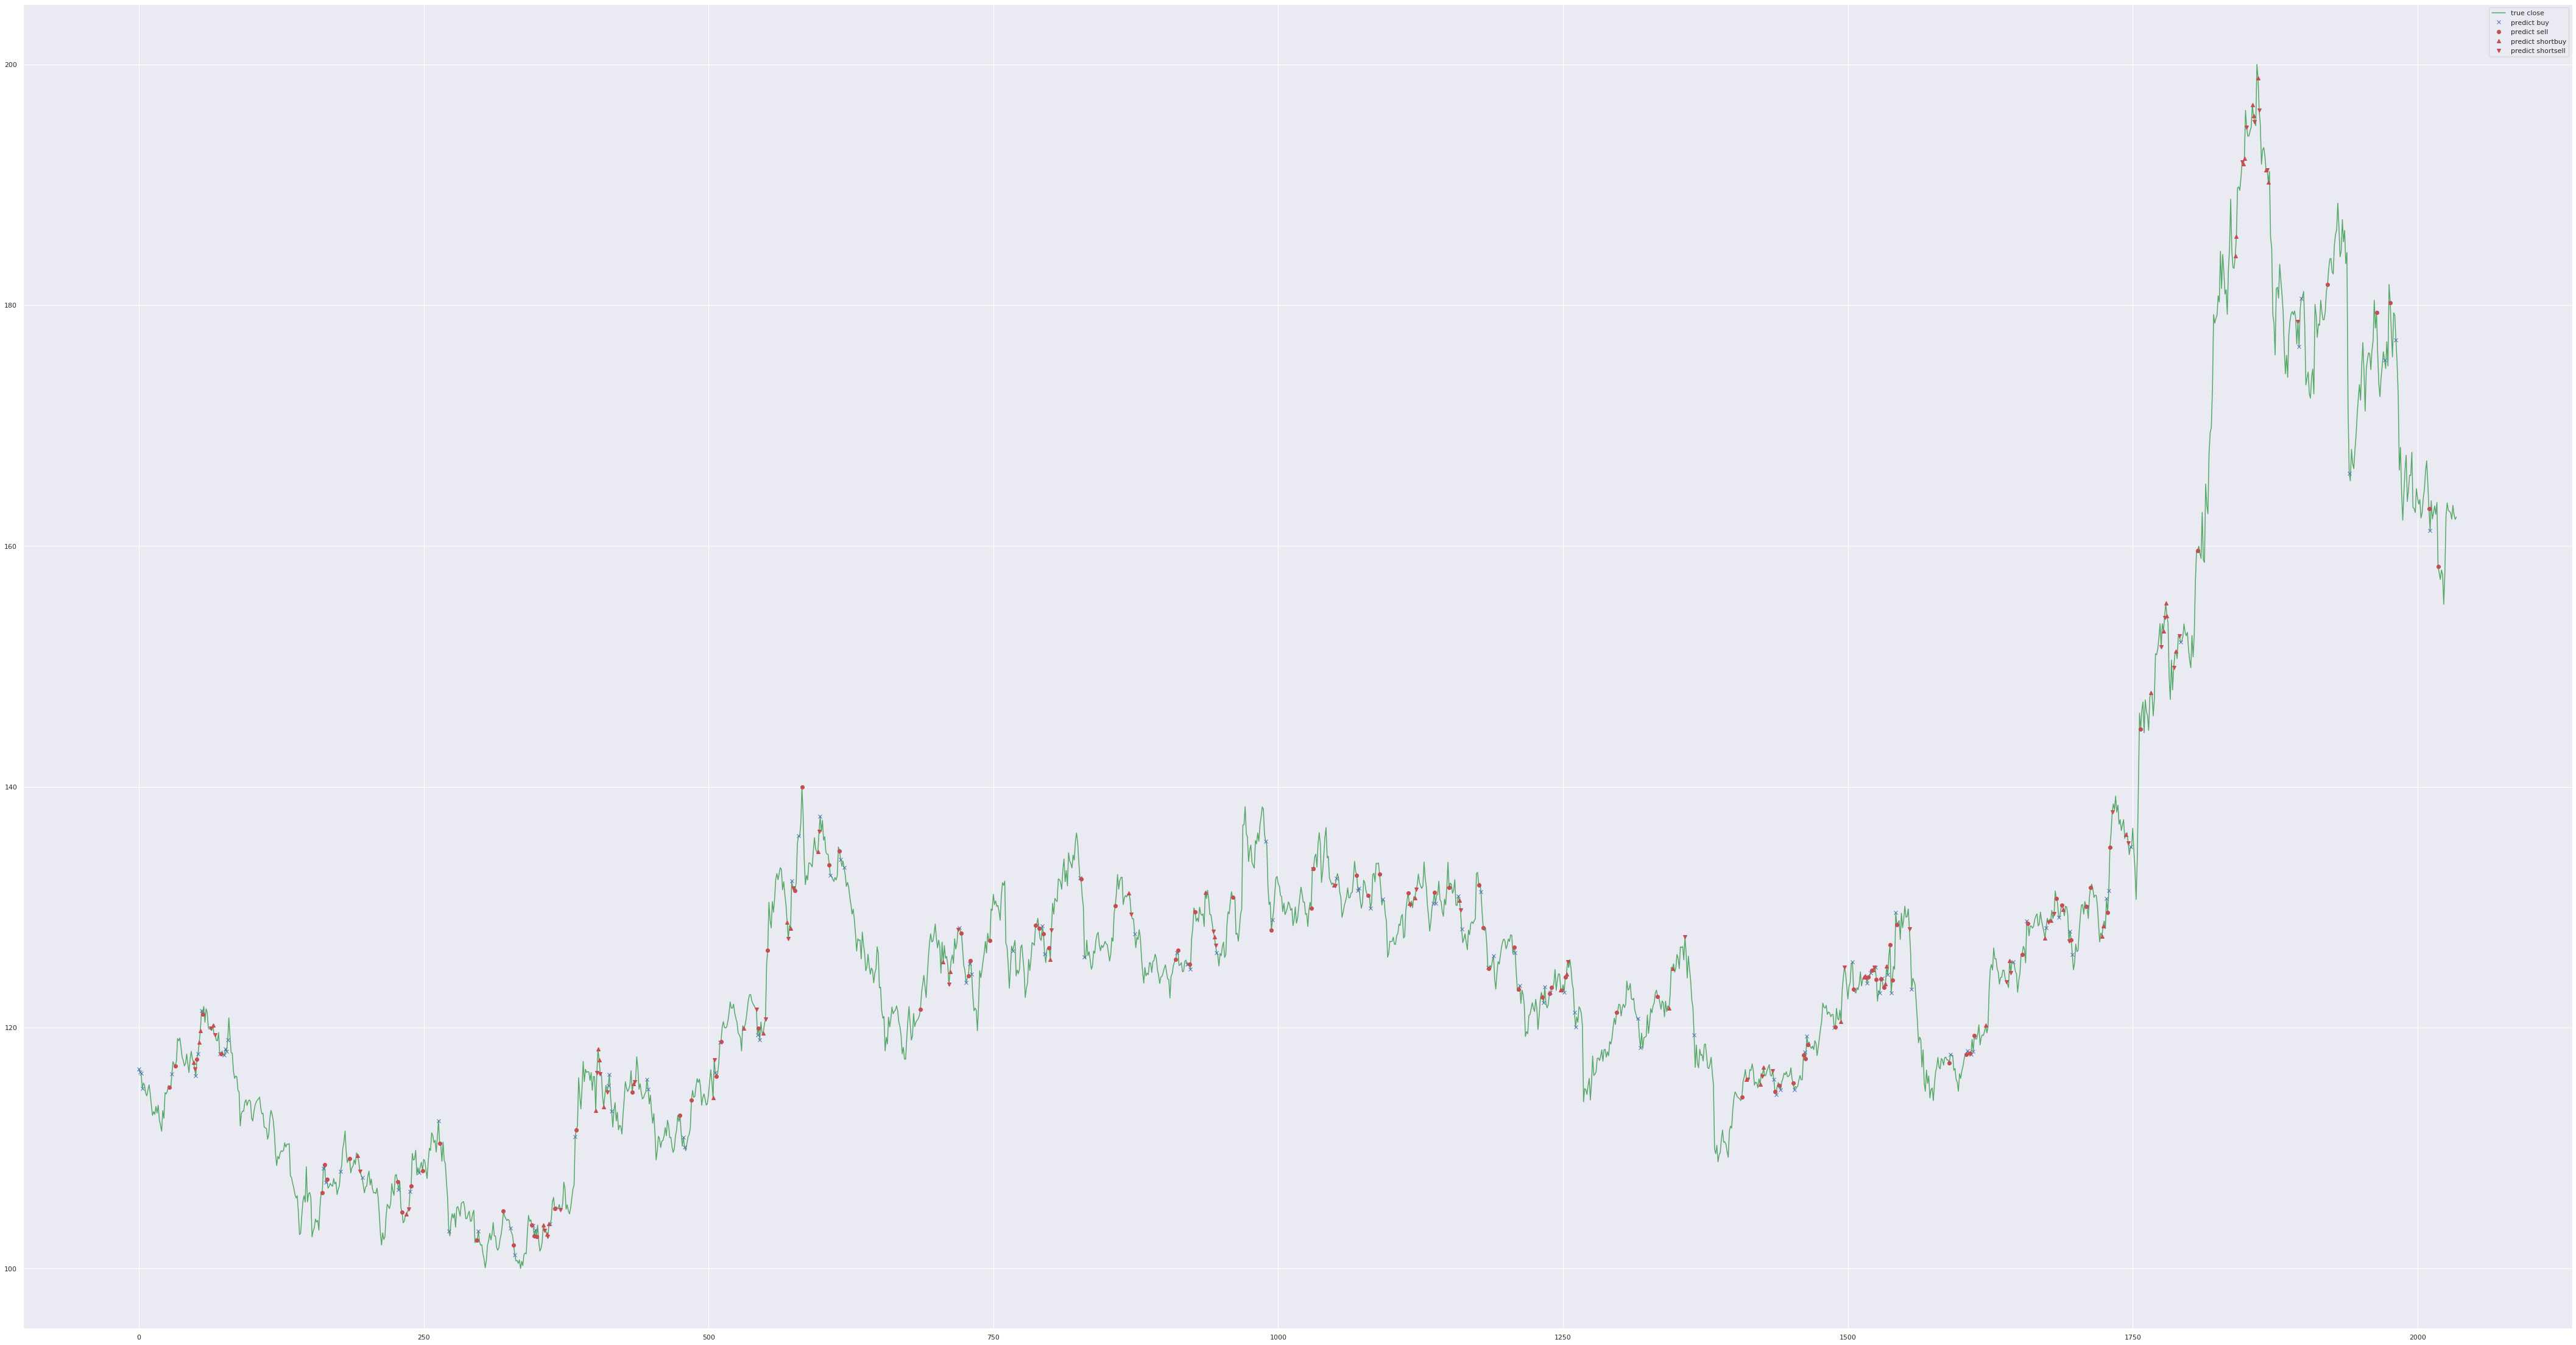

In [ ]:
states_buy, states_sell, states_shortbuy, states_shortsell, total_gains, invest = agent.buy()

In [ ]:
def best_agent(
    window_size, layer_size, output_size, skip, population_size, sigma, learning_rate
):
    model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
    agent = Agent(model = model,
                      population_size = population_size,
                      window_size= window_size,
                      sigma = sigma,
                      learning_rate = learning_rate,
                      timeseries = scaled_parameters,
                      skip = skip,
                      initial_money = initial_money,
                      max_buy = max_buy,
                      max_sell = max_sell,
                      real_trend = real_trend,
                      minmax = minmax)
    agent.fit(50, 10)
    return agent.es.reward_function(agent.es.weights)

def find_best_agent(
      window_size, layer_size, output_size, skip, population_size, sigma, learning_rate
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'layer_size': int(np.around(layer_size)),
        'output_size': int(np.around(output_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [ ]:
pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (3, 50),
        'layer_size': (200, 2500),
        'output_size': (2, 10),
        'skip': (1, 7),
        'population_size': (1, 50),
        'sigma': (0.01, 0.5),
        'learning_rate': (0.00001, 0.49),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 150, acq = 'ei', xi = 0.0)

|   iter    |  target   | layer_... | learni... | output... | popula... |   sigma   |   skip    | window... |
-------------------------------------------------------------------------------------------------------------

Search parameters {'window_size': 47, 'layer_size': 2363, 'output_size': 5, 'skip': 6, 'population_size': 2, 'sigma': 0.01849126585692707, 'learning_rate': 0.3983242925805238}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -66.415172
iter 20. reward: -66.415172
iter 30. reward: -66.415172
iter 40. reward: -66.415172
iter 50. reward: -66.415172
time taken to train: 21.17462706565857 seconds
stop after 100 iteration with investment -66.415172
|  1        | -66.42    |  2.363e+0 |  0.3983   |  5.309    |  2.389    |  0.01849  |  6.257    |  47.17    |

Search parameters {'window_size': 47, 'layer_size': 1439, 'output_size': 5, 'skip': 6, 'population_size': 15, 'sigma': 0.3963537478936081, 'learning_rate': 0.08317177844237068}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -96.876870
iter 20. reward: -65.837952
iter 30. reward: -63.911784
iter 40. reward: -8.748075
iter 50. reward: 61.081652
time taken to train: 110.19179272651672 seconds
stop after 100 iteration with investment 61.081652
|  2        |  61.08    |  1.439e+0 |  0.08317  |  4.522    |  15.27    |  0.3964   |  6.462    |  46.54    |

Search parameters {'window_size': 50, 'layer_size': 2082, 'output_size': 4, 'skip': 6, 'population_size': 16, 'sigma': 0.25855910257823933, 'learning_rate': 0.4744009862031757}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -67.082957
iter 20. reward: -64.971861
iter 30. reward: -49.837756
iter 40. reward: -51.024187
iter 50. reward: -52.780427
time taken to train: 140.34347820281982 seconds
stop after 100 iteration with investment -52.780427
|  3        | -52.78    |  2.082e+0 |  0.4744   |  3.825    |  15.58    |  0.2586   |  5.804    |  49.78    |

Search parameters {'window_size': 46, 'layer_size': 1913, 'output_size': 4, 'skip': 4, 'population_size': 30, 'sigma': 0.48569501201277965, 'learning_rate': 0.06659923931986927}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 10. reward: -147.990358
iter 20. reward: -151.352698
iter 30. reward: -56.939535
iter 40. reward: -69.198600
iter 50. reward: -61.970615
time taken to train: 340.58404541015625 seconds
stop after 100 iteration with investment -61.970615
|  4        | -61.97    |  1.913e+0 |  0.0666   |  4.31     |  30.04    |  0.4857   |  3.861    |  46.29    |

Search parameters {'window_size': 30, 'layer_size': 1874, 'output_size': 8, 'skip': 7, 'population_size': 15, 'sigma': 0.10292580712365425, 'learning_rate': 0.47194454941806396}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 1.434774
iter 20. reward: -167.674826
iter 30. reward: -59.909436
iter 40. reward: -147.513262
iter 50. reward: -77.660383
time taken to train: 105.10955810546875 seconds
stop after 100 iteration with investment -77.660383
|  5        | -77.66    |  1.874e+0 |  0.4719   |  8.353    |  14.97    |  0.1029   |  6.843    |  30.12    |

Search parameters {'window_size': 30, 'layer_size': 2332, 'output_size': 8, 'skip': 4, 'population_size': 15, 'sigma': 0.280058290958427, 'learning_rate': 0.48214699086193646}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 33.457659
iter 20. reward: 10.728038
iter 30. reward: 27.202698
iter 40. reward: 36.385966
iter 50. reward: 48.123520
time taken to train: 187.06141448020935 seconds
stop after 100 iteration with investment 48.123520
|  6        |  48.12    |  2.332e+0 |  0.4821   |  8.133    |  14.65    |  0.2801   |  4.108    |  30.36    |

Search parameters {'window_size': 31, 'layer_size': 1187, 'output_size': 6, 'skip': 5, 'population_size': 24, 'sigma': 0.3710577370912684, 'learning_rate': 0.23805294846911348}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -19.635738
iter 20. reward: 106.354627
iter 30. reward: 141.865359
iter 40. reward: 154.927650
iter 50. reward: 135.174908
time taken to train: 179.92276525497437 seconds
stop after 100 iteration with investment 135.174908
|  7        |  135.2    |  1.187e+0 |  0.2381   |  6.1      |  23.58    |  0.3711   |  5.283    |  30.57    |

Search parameters {'window_size': 10, 'layer_size': 1276, 'output_size': 2, 'skip': 5, 'population_size': 4, 'sigma': 0.4216182102653048, 'learning_rate': 0.2006701383356375}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 10. reward: -68.315934
iter 20. reward: -69.530867
iter 30. reward: -68.493363
iter 40. reward: -68.577566
iter 50. reward: -85.505435
time taken to train: 35.443286418914795 seconds
stop after 100 iteration with investment -85.505435
|  8        | -85.51    |  1.276e+0 |  0.2007   |  2.212    |  4.302    |  0.4216   |  5.439    |  10.37    |

Search parameters {'window_size': 45, 'layer_size': 1264, 'output_size': 7, 'skip': 7, 'population_size': 23, 'sigma': 0.15917168810360718, 'learning_rate': 0.08664800066964215}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 1.755038
iter 20. reward: 63.328992
iter 30. reward: 78.027543
iter 40. reward: 112.603858
iter 50. reward: 118.351442
time taken to train: 134.7665455341339 seconds
stop after 100 iteration with investment 118.351442
|  9        |  118.4    |  1.264e+0 |  0.08665  |  6.944    |  23.44    |  0.1592   |  6.636    |  44.72    |

Search parameters {'window_size': 18, 'layer_size': 378, 'output_size': 3, 'skip': 4, 'population_size': 39, 'sigma': 0.10758535821342194, 'learning_rate': 0.23869009884561077}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 10. reward: 62.409502
iter 20. reward: 73.791223
iter 30. reward: 95.186131
iter 40. reward: 70.995014
iter 50. reward: 78.577137
time taken to train: 261.86281657218933 seconds
stop after 100 iteration with investment 78.577137
|  10       |  78.58    |  377.6    |  0.2387   |  3.218    |  38.56    |  0.1076   |  4.283    |  18.02    |

Search parameters {'window_size': 14, 'layer_size': 1218, 'output_size': 9, 'skip': 3, 'population_size': 6, 'sigma': 0.39149763222392764, 'learning_rate': 0.019604300588322}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -57.107957
iter 20. reward: -47.011941
iter 30. reward: -60.491043
iter 40. reward: -260.868416
iter 50. reward: -75.780384
time taken to train: 76.30299758911133 seconds
stop after 100 iteration with investment -75.780384
|  11       | -75.78    |  1.218e+0 |  0.0196   |  8.815    |  6.433    |  0.3915   |  3.495    |  14.11    |

Search parameters {'window_size': 16, 'layer_size': 2036, 'output_size': 4, 'skip': 4, 'population_size': 1, 'sigma': 0.2880641660245913, 'learning_rate': 0.35679313980587307}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -123.474732
iter 20. reward: -123.474732


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 30. reward: -123.474732
iter 40. reward: -123.474732
iter 50. reward: -123.474732
time taken to train: 14.164080142974854 seconds
stop after 100 iteration with investment -123.474732
|  12       | -123.5    |  2.036e+0 |  0.3568   |  3.75     |  1.321    |  0.2881   |  4.239    |  16.41    |

Search parameters {'window_size': 39, 'layer_size': 2044, 'output_size': 9, 'skip': 5, 'population_size': 14, 'sigma': 0.07217136097374999, 'learning_rate': 0.4686303774382321}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 3.111208
iter 20. reward: -96.667820
iter 30. reward: 16.273564
iter 40. reward: 55.240665
iter 50. reward: -70.489213
time taken to train: 134.38730335235596 seconds
stop after 100 iteration with investment -70.489213
|  13       | -70.49    |  2.044e+0 |  0.4686   |  9.15     |  14.43    |  0.07217  |  4.777    |  38.82    |

Search parameters {'window_size': 43, 'layer_size': 1509, 'output_size': 9, 'skip': 4, 'population_size': 22, 'sigma': 0.4794313102053705, 'learning_rate': 0.03810699051407836}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 8.118147
iter 20. reward: 3.331369
iter 30. reward: -148.582275
iter 40. reward: -91.633686
iter 50. reward: -45.648265
time taken to train: 232.34744787216187 seconds
stop after 100 iteration with investment -45.648265
|  14       | -45.65    |  1.509e+0 |  0.03811  |  9.399    |  21.65    |  0.4794   |  3.64     |  43.49    |

Search parameters {'window_size': 22, 'layer_size': 1342, 'output_size': 5, 'skip': 3, 'population_size': 34, 'sigma': 0.12168488302522984, 'learning_rate': 0.05624170850927069}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 74.865507
iter 20. reward: 123.826954
iter 30. reward: 214.736555
iter 40. reward: 225.114459
iter 50. reward: 274.024574
time taken to train: 444.3408215045929 seconds
stop after 100 iteration with investment 274.024574
|  15       |  274.0    |  1.342e+0 |  0.05624  |  4.955    |  33.97    |  0.1217   |  2.775    |  21.66    |

Search parameters {'window_size': 8, 'layer_size': 1777, 'output_size': 7, 'skip': 5, 'population_size': 16, 'sigma': 0.0562732726249235, 'learning_rate': 0.4402318751485474}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -5.987455
iter 20. reward: -34.442250
iter 30. reward: -53.367794
iter 40. reward: -300.523270
iter 50. reward: -300.523270
time taken to train: 147.29999780654907 seconds
stop after 100 iteration with investment -300.523270
|  16       | -300.5    |  1.777e+0 |  0.4402   |  7.03     |  16.14    |  0.05627  |  5.299    |  7.734    |

Search parameters {'window_size': 34, 'layer_size': 1951, 'output_size': 9, 'skip': 7, 'population_size': 32, 'sigma': 0.205527150069852, 'learning_rate': 0.15999267286223742}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 10. reward: 2.695031
iter 20. reward: 162.842415
iter 30. reward: 144.396528
iter 40. reward: 145.037882
iter 50. reward: 158.595889
time taken to train: 230.2711741924286 seconds
stop after 100 iteration with investment 158.595889
|  17       |  158.6    |  1.951e+0 |  0.16     |  8.665    |  32.42    |  0.2055   |  6.707    |  33.96    |

Search parameters {'window_size': 45, 'layer_size': 1232, 'output_size': 7, 'skip': 6, 'population_size': 4, 'sigma': 0.46270857471278076, 'learning_rate': 0.11197320352172266}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -63.136132
iter 20. reward: 6.103242
iter 30. reward: 1.112146
iter 40. reward: 3.429678
iter 50. reward: -6.380669
time taken to train: 27.301358222961426 seconds
stop after 100 iteration with investment -6.380669
|  18       | -6.381    |  1.232e+0 |  0.112    |  6.755    |  3.767    |  0.4627   |  6.468    |  44.55    |

Search parameters {'window_size': 35, 'layer_size': 1807, 'output_size': 10, 'skip': 7, 'population_size': 15, 'sigma': 0.11093192990125314, 'learning_rate': 0.034837656515650614}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -64.050237
iter 20. reward: 24.765837


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 30. reward: 166.616428
iter 40. reward: 193.456960
iter 50. reward: 196.565732
time taken to train: 108.30290150642395 seconds
stop after 100 iteration with investment 196.565732
|  19       |  196.6    |  1.807e+0 |  0.03484  |  9.551    |  14.63    |  0.1109   |  6.63     |  34.7     |

Search parameters {'window_size': 9, 'layer_size': 1140, 'output_size': 2, 'skip': 5, 'population_size': 37, 'sigma': 0.3940413915071899, 'learning_rate': 0.2577576066752174}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 10. reward: -66.785239
iter 20. reward: -72.351678
iter 30. reward: -67.152124
iter 40. reward: 0.000000
iter 50. reward: 0.000000
time taken to train: 282.53132939338684 seconds
stop after 100 iteration with investment 0.000000
|  20       |  0.0      |  1.14e+03 |  0.2578   |  2.162    |  37.04    |  0.394    |  4.731    |  9.039    |

Search parameters {'window_size': 39, 'layer_size': 1967, 'output_size': 6, 'skip': 4, 'population_size': 13, 'sigma': 0.020028170876518803, 'learning_rate': 0.4191373326371054}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -68.427203
iter 20. reward: -68.427203
iter 30. reward: -68.427203
iter 40. reward: -68.427203
iter 50. reward: -68.427203
time taken to train: 145.1051151752472 seconds
stop after 100 iteration with investment -68.427203
|  21       | -68.43    |  1.967e+0 |  0.4191   |  5.876    |  12.84    |  0.02003  |  4.396    |  38.64    |

Search parameters {'window_size': 32, 'layer_size': 2181, 'output_size': 4, 'skip': 5, 'population_size': 42, 'sigma': 0.12790557118918236, 'learning_rate': 0.2978075618883107}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -59.922500


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 20. reward: -62.099420
iter 30. reward: -59.340656
iter 40. reward: -63.861995
iter 50. reward: -68.168578
time taken to train: 443.74641251564026 seconds
stop after 100 iteration with investment -68.168578
|  22       | -68.17    |  2.181e+0 |  0.2978   |  4.324    |  41.63    |  0.1279   |  5.117    |  32.28    |

Search parameters {'window_size': 29, 'layer_size': 489, 'output_size': 5, 'skip': 5, 'population_size': 38, 'sigma': 0.14170739896583956, 'learning_rate': 0.28669288886211697}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 0.828904
iter 20. reward: 7.137517
iter 30. reward: 70.796481
iter 40. reward: 77.451821
iter 50. reward: -189.276969
time taken to train: 208.07908868789673 seconds
stop after 100 iteration with investment -189.276969
|  23       | -189.3    |  489.1    |  0.2867   |  5.262    |  38.06    |  0.1417   |  5.179    |  29.39    |

Search parameters {'window_size': 42, 'layer_size': 1458, 'output_size': 5, 'skip': 5, 'population_size': 3, 'sigma': 0.3195332084840413, 'learning_rate': 0.31676297839203543}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -50.003338
iter 20. reward: -310.888610
iter 30. reward: -10.651592
iter 40. reward: 17.881041
iter 50. reward: 52.852601
time taken to train: 27.395220518112183 seconds
stop after 100 iteration with investment 52.852601
|  24       |  52.85    |  1.458e+0 |  0.3168   |  5.028    |  3.34     |  0.3195   |  4.934    |  41.69    |

Search parameters {'window_size': 24, 'layer_size': 1464, 'output_size': 9, 'skip': 1, 'population_size': 28, 'sigma': 0.10356773882644053, 'learning_rate': 0.11110034545678174}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 136.857413
iter 20. reward: 104.194476
iter 30. reward: 129.113717
iter 40. reward: -245.336424
iter 50. reward: -43.791726
time taken to train: 1064.8850619792938 seconds
stop after 100 iteration with investment -43.791726
|  25       | -43.79    |  1.464e+0 |  0.1111   |  9.137    |  27.99    |  0.1036   |  1.14     |  23.86    |

Search parameters {'window_size': 35, 'layer_size': 655, 'output_size': 7, 'skip': 4, 'population_size': 48, 'sigma': 0.018716542625848, 'learning_rate': 0.015878015265319827}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -48.269536
iter 20. reward: 159.185964
iter 30. reward: 142.967445
iter 40. reward: 8.264974
iter 50. reward: 49.443777
time taken to train: 371.157842874527 seconds
stop after 100 iteration with investment 49.443777
|  26       |  49.44    |  655.0    |  0.01588  |  6.946    |  47.82    |  0.01872  |  3.747    |  35.33    |

Search parameters {'window_size': 41, 'layer_size': 691, 'output_size': 3, 'skip': 6, 'population_size': 17, 'sigma': 0.05498595593773196, 'learning_rate': 0.3994342920905202}
iter 10. reward: -55.714905
iter 20. reward: -12.893288
iter 30. reward: 31.764181
iter 40. reward: -66.204837
iter 50. reward: 20.508530
time taken to train: 96.3974838256836 seconds
stop after 100 iteration with investment 20.508530
|  27       |  20.51    |  691.5    |  0.3994   |  3.422    |  16.76    |  0.05499  |  5.928    |  41.23    |

Search parameters {'window_size': 50, 'layer_size': 1098, 'output_size': 7, 'skip': 4, 'population_size': 6, 'sigma': 0.4903144360677

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 16.541139
iter 20. reward: 20.197323
iter 30. reward: -79.078976
iter 40. reward: 16.403774
iter 50. reward: -55.246744
time taken to train: 58.02354550361633 seconds
stop after 100 iteration with investment -55.246744
|  28       | -55.25    |  1.098e+0 |  0.1755   |  7.305    |  5.792    |  0.4903   |  3.93     |  49.58    |

Search parameters {'window_size': 10, 'layer_size': 1469, 'output_size': 8, 'skip': 2, 'population_size': 8, 'sigma': 0.409068548558377, 'learning_rate': 0.4574985678048022}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 7.309825
iter 20. reward: 114.058217
iter 30. reward: 84.289650
iter 40. reward: 34.263977
iter 50. reward: 74.333148
time taken to train: 157.2737102508545 seconds
stop after 100 iteration with investment 74.333148
|  29       |  74.33    |  1.469e+0 |  0.4575   |  7.831    |  8.487    |  0.4091   |  2.352    |  9.765    |

Search parameters {'window_size': 30, 'layer_size': 2033, 'output_size': 5, 'skip': 3, 'population_size': 17, 'sigma': 0.17442105833028163, 'learning_rate': 0.15634634691215132}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: 68.935908
iter 20. reward: 47.273816
iter 30. reward: 90.750983
iter 40. reward: 101.283863
iter 50. reward: 95.769792
time taken to train: 255.9611418247223 seconds
stop after 100 iteration with investment 95.769792
|  30       |  95.77    |  2.033e+0 |  0.1563   |  5.344    |  16.97    |  0.1744   |  2.523    |  29.69    |

Search parameters {'window_size': 7, 'layer_size': 2496, 'output_size': 7, 'skip': 3, 'population_size': 42, 'sigma': 0.11504328440814245, 'learning_rate': 0.2506565275550726}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -0.812365
iter 20. reward: 101.823714
iter 30. reward: 56.565612
iter 40. reward: 74.454439
iter 50. reward: 85.966009
time taken to train: 690.3274199962616 seconds
stop after 100 iteration with investment 85.966009
|  31       |  85.97    |  2.496e+0 |  0.2507   |  7.374    |  42.3     |  0.115    |  3.01     |  7.334    |

Search parameters {'window_size': 44, 'layer_size': 1581, 'output_size': 4, 'skip': 5, 'population_size': 14, 'sigma': 0.2756049404194089, 'learning_rate': 0.16874203012683223}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -57.237187
iter 20. reward: -66.073273
iter 30. reward: -48.325152
iter 40. reward: -50.545990
iter 50. reward: -69.226512
time taken to train: 124.1405119895935 seconds
stop after 100 iteration with investment -69.226512
|  32       | -69.23    |  1.581e+0 |  0.1687   |  3.911    |  14.21    |  0.2756   |  5.309    |  43.7     |

Search parameters {'window_size': 34, 'layer_size': 1797, 'output_size': 6, 'skip': 5, 'population_size': 35, 'sigma': 0.47678014382714523, 'learning_rate': 0.10380805992647486}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -54.975727
iter 20. reward: -23.892684
iter 30. reward: 2.909470
iter 40. reward: -26.204678
iter 50. reward: -43.558456
time taken to train: 317.52835869789124 seconds
stop after 100 iteration with investment -43.558456
|  33       | -43.56    |  1.797e+0 |  0.1038   |  5.943    |  34.7     |  0.4768   |  4.842    |  33.85    |

Search parameters {'window_size': 31, 'layer_size': 2372, 'output_size': 10, 'skip': 2, 'population_size': 33, 'sigma': 0.25946241548267696, 'learning_rate': 0.2479239987631559}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -6.050704


KeyboardInterrupt: ignored

In [ ]:
def getMax(d):
  max = 0.0
  params ={}
  for s in d:
    if s['target'] > max:
      max = s['target']
      params = s['params']
  return max, params

m, p = getMax(NN_BAYESIAN.res)
print('Best AGENT accuracy value: %f' % m)
print('Best AGENT parameters: ', p)

Best AGENT accuracy value: 274.024574
Best AGENT parameters:  {'layer_size': 1341.546570114487, 'learning_rate': 0.05624170850927069, 'output_size': 4.9553028568551865, 'population_size': 33.97247632373019, 'sigma': 0.12168488302522984, 'skip': 2.774953593665387, 'window_size': 21.66059603243273}


In [ ]:
import json
bayes_res = str(p)
bayes_res = json.loads(bayes_res.replace("'", "\""))
bayes_res['window_size'] = int(round(bayes_res['window_size']))
bayes_res['layer_size'] = int(round(bayes_res['layer_size']))
bayes_res['output_size'] = int(round(bayes_res['output_size']))
bayes_res['skip'] = int(round(bayes_res['skip']))
bayes_res['population_size'] = int(round(bayes_res['population_size']))
bayes_res['sigma'] = float(round(bayes_res['sigma'], 2))
bayes_res['learning_rate'] = float(round(bayes_res['learning_rate'], 5))
print(bayes_res)

{'layer_size': 1342, 'learning_rate': 0.05624, 'output_size': 5, 'population_size': 34, 'sigma': 0.12, 'skip': 3, 'window_size': 22}


In [ ]:
# this is from bayesian
best_agent(bayes_res['window_size'], 
           bayes_res['layer_size'], 
           bayes_res['output_size'],
           bayes_res['skip'], 
           bayes_res['population_size'], 
           bayes_res['sigma'], 
           bayes_res['learning_rate'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 10. reward: -60.151222
iter 20. reward: 219.872098
iter 30. reward: 532.251579
iter 40. reward: 635.531802
iter 50. reward: 543.932543
time taken to train: 458.65292143821716 seconds


543.9325431169899

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in double_scalars


iter 5. reward: -17.069210
iter 10. reward: 187.040477
iter 15. reward: 140.545598
iter 20. reward: 157.890121
iter 25. reward: 156.074779
iter 30. reward: 161.998311
iter 35. reward: 117.889271
iter 40. reward: 314.200078
iter 45. reward: 327.480259
iter 50. reward: 355.635169
iter 55. reward: 500.311102


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter 60. reward: 311.743892
iter 65. reward: 501.459192
iter 70. reward: 520.552747
iter 75. reward: 502.302423
iter 80. reward: 458.016088
iter 85. reward: 332.636258
iter 90. reward: 344.522491
iter 95. reward: 346.154171
iter 100. reward: -47.639032
iter 105. reward: 449.325117
iter 110. reward: 335.706702
iter 115. reward: 292.926085
iter 120. reward: 528.208245
iter 125. reward: 507.023765
iter 130. reward: 498.214915
iter 135. reward: 473.510218
iter 140. reward: 485.445314
iter 145. reward: 496.660194
iter 150. reward: 335.122206
iter 155. reward: 494.597536
iter 160. reward: 508.666058
iter 165. reward: 511.057461
iter 170. reward: 477.270333
iter 175. reward: 517.576131
iter 180. reward: 506.423221
iter 185. reward: 498.676893
iter 190. reward: 505.266733
iter 195. reward: 514.927570
iter 200. reward: 516.365373
iter 205. reward: 516.500993
iter 210. reward: 509.646107
iter 215. reward: 523.833089
iter 220. reward: 518.391809
iter 225. reward: 508.172733
iter 230. reward: 516.

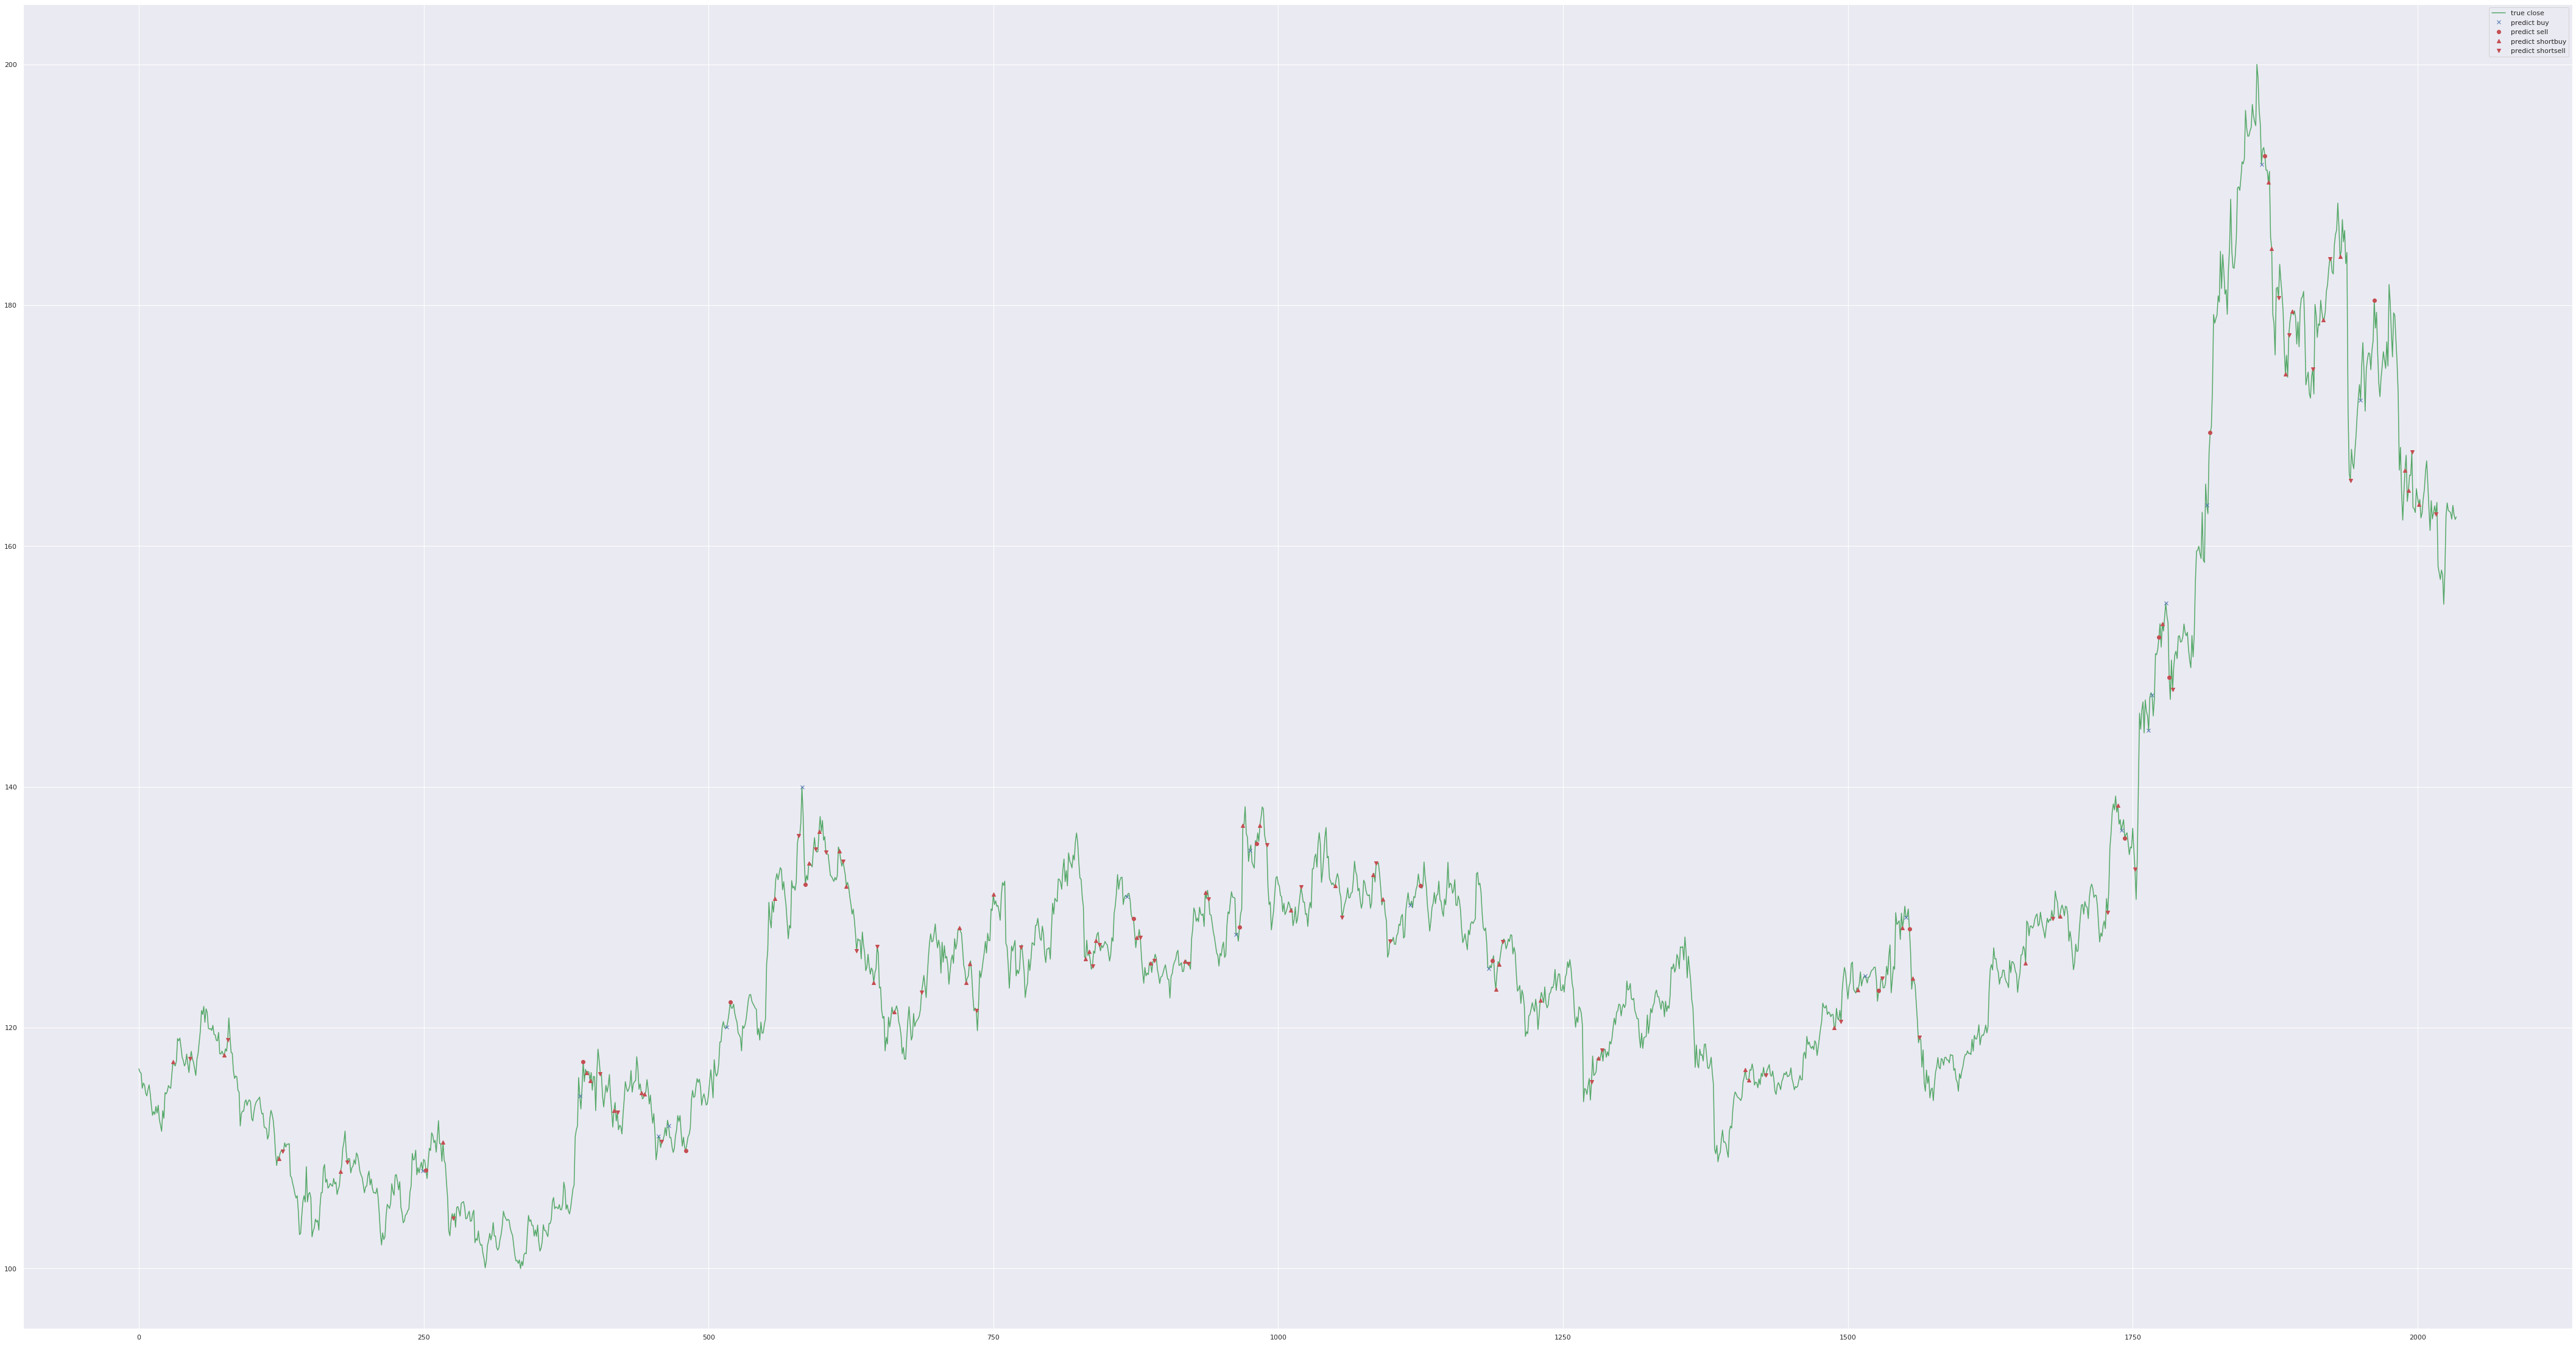

In [ ]:
# this is from bayesian
model = Model(input_size = input_size, layer_size = bayes_res['layer_size'], output_size = bayes_res['output_size'])
agent = Agent(model = model,
                  population_size = bayes_res['population_size'],
                  window_size= bayes_res['window_size'],
                  sigma = bayes_res['sigma'],
                  learning_rate = bayes_res['learning_rate'],
                  timeseries = scaled_parameters,
                  skip = bayes_res['skip'],
                  initial_money = initial_money,
                  max_buy = max_buy,
                  max_sell = max_sell,
                  real_trend = real_trend,
                  minmax = minmax)
agent.fit(250, 5)
states_buy, states_sell, states_shortbuy, states_shortsell, total_gains, invest = agent.buy()